In [1]:
# build a database for the web app populating it will all sequences

In [2]:
import os
import re
import sys
import csv
import time
import shutil
import random
import sqlite3
import requests
import subprocess
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
base_dir = Path.cwd().parent
data_dir = base_dir / 'data'

reference_data = {
    11676: {"accid": "K03455.1",
            "organism": "HIV-1",
            "fasta": data_dir / "reference/K03455.1.fasta",
            "gtf": data_dir / "reference/K03455.1.gtf",
            "description": 'Human immunodeficiency virus type 1 (HXB2), complete genome; HIV1/HTLV-III/LAV reference genome'},
    11723: {"accid": "M33262.1",
            "organism": "SIV",
            "fasta": data_dir / "reference/M33262.1.fasta",
            "gtf": data_dir / "reference/M33262.1.gtf",
            "description": 'Simian (macaque) immunodeficiency virus, isolate 239, complete proviral genome.'}
}
reference_ids = set([x["accid"] for x in reference_data.values()])

sequence_dir = data_dir / 'sequences'
assert sequence_dir.exists(), f"sequence_dir does not exist: {sequence_dir}"

outdir = data_dir / 'annotation'
outdir.mkdir(exist_ok=True)

release_dir = Path.cwd().parent.parent / 'HIV_Atlas_Data'
assert release_dir.exists(), f"release_dir does not exist: {release_dir}"
release_data_dir = release_dir / 'data'
release_data_dir.mkdir(exist_ok=True)
release_db_file = release_dir / 'hiv_atlas.db.tsv'

accession_list_fname = data_dir / 'complete_sequences.2022.accessions'
summary_file = data_dir / "download.summary.tsv"

annotation_log_fname = outdir / 'log.txt'
# load the annotation log file to extract relevant data into the database tsv
log_df = pd.read_csv(annotation_log_fname)


In [4]:
reference_data

{11676: {'accid': 'K03455.1',
  'organism': 'HIV-1',
  'fasta': PosixPath('/ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Creation/data/reference/K03455.1.fasta'),
  'gtf': PosixPath('/ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Creation/data/reference/K03455.1.gtf'),
  'description': 'Human immunodeficiency virus type 1 (HXB2), complete genome; HIV1/HTLV-III/LAV reference genome'},
 11723: {'accid': 'M33262.1',
  'organism': 'SIV',
  'fasta': PosixPath('/ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Creation/data/reference/M33262.1.fasta'),
  'gtf': PosixPath('/ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Creation/data/reference/M33262.1.gtf'),
  'description': 'Simian (macaque) immunodeficiency virus, isolate 239, complete proviral genome.'}}

In [5]:
def build_genome_files(fasta_fname, gtf_fname, out_base_name):
    """Build the genome files for the database."""

    cmds = []

    # create copies of fasta and gtf files
    new_fasta_fname = f"{out_base_name}.fasta"
    new_gtf_fname = f"{out_base_name}.gtf"
    shutil.copy(fasta_fname, new_fasta_fname)
    shutil.copy(gtf_fname, new_gtf_fname)

    # create fasta index
    cmds.append(f"samtools faidx {new_fasta_fname}")

    # create sorted gff: gffread -F --keep-exon-attrs -o- K03455.1.gtf | sort -k1,1 -k4,4n > K03455.1.sorted.gff
    gff_fname = outdir / f"{out_base_name}.gff"
    cmds.append(f"gffread -F --keep-exon-attrs -o- {new_gtf_fname} | sort -k1,1 -k4,4n > {gff_fname}")

    # compress the gff file with bgzip - keep the original
    cmds.append(f"bgzip -k {gff_fname}")

    # create tabix index
    cmds.append(f"tabix -p gff {gff_fname}.gz")

    # return dictionary of file names
    return {
        'fasta': new_fasta_fname,
        'fai': f"{new_fasta_fname}.fai",
        'gtf': new_gtf_fname,
        'gff': f"{gff_fname}.gz",
        'tbi': f"{gff_fname}.gz.tbi",
        'cmds': "\n".join(cmds)
    }

In [6]:
with open(release_data_dir / 'commands.sh', 'w') as outFP:
    for taxid, ref_data in reference_data.items():
        genome_db_outdir = release_data_dir / ref_data["accid"]
        genome_db_outdir.mkdir(exist_ok=True)

        genome_data = build_genome_files(ref_data["fasta"], ref_data["gtf"], genome_db_outdir / ref_data["accid"])
        # write the commands to a file
        outFP.write(genome_data['cmds']+"\n")

In [9]:
# read summary tsv line by line using csv module
with open(release_data_dir / 'commands.sh', 'a') as outFP:
    with open(summary_file,"r") as inFP:
        reader = csv.reader(inFP, delimiter="\t")
        # skip header
        next(reader)
        for lno, (accid, is_ref_genome, organism, taxid, fasta, gff, is_valid, ref_start, ref_end) in enumerate(reader):
            if accid in reference_ids:
                continue

            if (outdir / accid / f"{accid}.vira.gtf").exists():
                if len(log_df[log_df["accid"]==accid]) == 0:
                    print(f"Warning: {accid} not found in log file, skipping")
                    continue
                log_row = log_df[log_df["accid"]==accid]
                assert len(log_row) == 1, f"Error: multiple rows found for {accid}"

                status = log_row["status"].values[0]
                if not status == "complete":
                    print(f"Warning: {accid} is not complete, skipping")
                    continue

                acc_outdir = outdir / accid
                acc_outdir.mkdir(exist_ok=True)
                genome_fasta_fname = sequence_dir / f"{accid}.fasta"
                genome_gtf_fname = acc_outdir / f"{accid}.vira.gtf"
                
                # create gff file, sort and compress and index
                genome_db_outdir = release_data_dir / accid
                genome_db_outdir.mkdir(exist_ok=True)

                genome_data = build_genome_files(genome_fasta_fname, genome_gtf_fname, genome_db_outdir / accid)
                # write the commands to a file
                with open(release_data_dir / 'commands.sh', 'a') as outFP:
                    outFP.write(genome_data['cmds']+"\n")

In [10]:
# run the commands.sh script
subprocess.run(["bash", "-x" , release_data_dir / 'commands.sh'])

+ samtools faidx /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Data/data/K03455.1/K03455.1.fasta
+ gffread -F --keep-exon-attrs -o- /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Data/data/K03455.1/K03455.1.gtf
+ sort -k1,1 -k4,4n
+ bgzip -k /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Data/data/K03455.1/K03455.1.gff
+ tabix -p gff /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Data/data/K03455.1/K03455.1.gff.gz
+ samtools faidx /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Data/data/M33262.1/M33262.1.fasta
+ gffread -F --keep-exon-attrs -o- /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Data/data/M33262.1/M33262.1.gtf
+ sort -k1,1 -k4,4n
+ bgzip -k /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Data/data/M33262.1/M33262.1.gff
+ tabix -p gff /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Data/data/M33262.1/M33262.1.gff.gz
[tabix] the index file exists. Please use '-f' to overwrite.
+ samtools faidx /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Data/data/MH705157.1/MH705157.1.fasta
+ gffread -F --keep-exon-attrs -o- /ccb/salz

CompletedProcess(args=['bash', '-x', PosixPath('/ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Data/data/commands.sh')], returncode=1)

In [11]:
# build
def get_description(fasta_fname):
    """Get the description from the fasta file."""
    with open(fasta_fname) as inFP:
        for line in inFP:
            if line.startswith('>'):
                return line.strip().split(" ",1)[-1]
            
    return ""

# initialize manual db file
db_tsvFP = open(release_db_file, "w") # format: accid, taxid, organism is_reference, description, genome_score, dir
 
for taxid, ref_data in reference_data.items():
    db_tsvFP.write(f"{ref_data['accid']}\t{taxid}\t{ref_data['organism']}\t1\t1.0\t{ref_data['description']}\n")

# read summary tsv line by line using csv module
with open(summary_file,"r") as inFP:
    reader = csv.reader(inFP, delimiter="\t")
    # skip header
    next(reader)
    for lno, (accid, is_ref_genome, organism, taxid, fasta, gff, is_valid, ref_start, ref_end) in enumerate(reader):
        if accid in reference_ids:
            continue

        if (outdir / accid / f"{accid}.vira.gtf").exists():
            genome_fasta_fname = sequence_dir / f"{accid}.fasta"
            
            # load line from the annotation log to get the score
            if len(log_df[log_df["accid"]==accid]) == 0:
                print(f"Warning: {accid} not found in log file, skipping")
                continue
            
            log_row = log_df[log_df["accid"]==accid]
            assert len(log_row) == 1, f"Error: multiple rows found for {accid}"

            genome_score = log_row["genome_score"].values[0]
            status = log_row["status"].values[0]
            if not status == "complete":
                print(f"Warning: {accid} is not complete, skipping")
                continue
            
            description = get_description(genome_fasta_fname)
            db_tsvFP.write(f"{accid}\t{taxid}\t{organism}\t0\t{genome_score}\t{description}\n")

db_tsvFP.close()

In [8]:
# cleanup uncompressed gff and gtf files
for accid in os.listdir(release_data_dir):
    accdir = release_data_dir / accid
    if not accdir.is_dir():
        continue

    for fname in os.listdir(accdir):
        if fname.endswith(".gff") or fname.endswith(".gtf"):
            os.remove(accdir / fname)

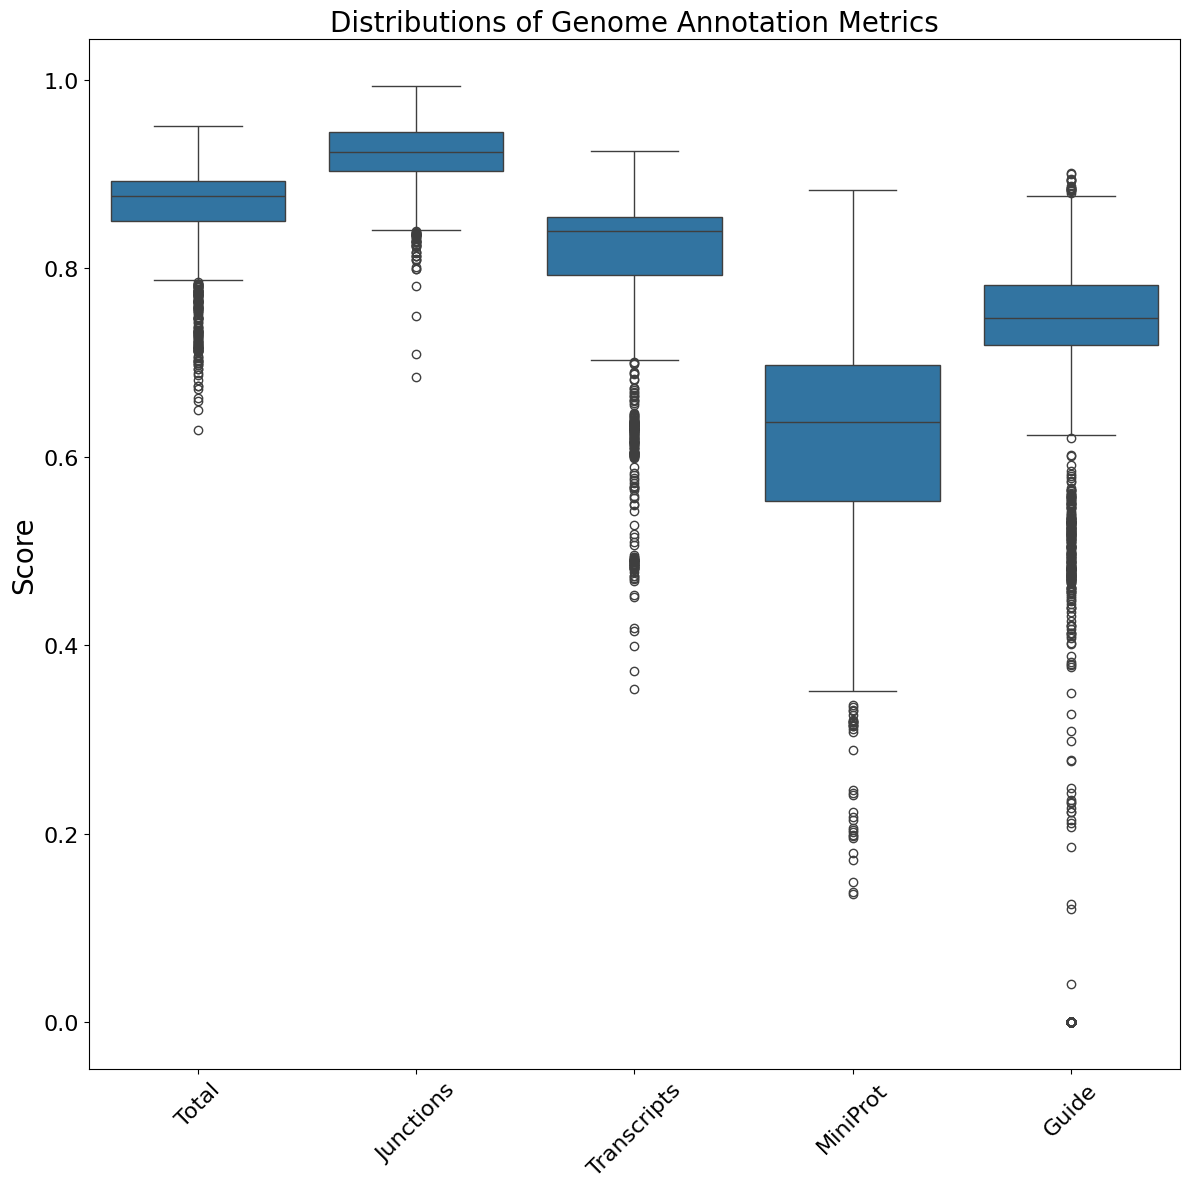

In [22]:
# build a plot visualizing the scores
# seaborn boxplots of genome_score, junction-score, transcript_score, miniprot_score, guide_score
complete_log_df = log_df[log_df["status"]=="complete"].reset_index(drop=True)
melted_df = complete_log_df.melt(
    id_vars=["accid", "organism", "status"],
    value_vars=["genome_score", "junction_score", "transcript_score", "miniprot_score", "guide_score"],
    var_name="Score Type",
    value_name="Score"
)

# Create a Seaborn boxplot
plt.figure(figsize=(12,12))
sns.boxplot(x="Score Type", y="Score", data=melted_df)
plt.title("Distributions of Genome Annotation Metrics", fontsize=20)
# set x-axis labels to "Total", Junction", "Transcript", "MiniProt", "Guide"
plt.xticks(ticks=range(5), labels=["Total", "Junctions", "Transcripts", "MiniProt", "Guide"])
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# increase font size for all text
plt.tick_params(axis='both', which='major', labelsize=16)
# remove x_label
plt.xlabel("")
# set y-axis label fontsize
plt.ylabel("Score", fontsize=20)
plt.tight_layout()
plt.show()